# Parameter Estimation for a Catalytic Reactor

This notebook demonstrates parameter estimation for a catalytic oxidation experiment that is conducted in the senior Chemical Engineering Laboratory course at Notre Dame. The reaction can be modeled as

\begin{align*}
\cal{A} \longrightarrow \mbox{Products}
\end{align*}

where concentration of $cal{A}$ is measured in the reactor feed and effluent streams. The reactor has very high internal recycle and is assumed to be operating as the equivalent of a stirred tank reactor.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import fmin

## Data

The data is taken from [course notes by Prof. David Leighton](https://www3.nd.edu/~dtl/cbe20258/notes/notes13.html) (also [here](https://www3.nd.edu/~dtl/cbe20258/notes/lecture13.pdf) and [here](https://www3.nd.edu/~dtl/cbe20258/examples/example18.m)). The data consists of measurements done for three different feed concentrations `Cr0`. For each feed concentration, students adjust reactor temperature `T` using an external heat source and measure the resulting effluent concentration `Cr`. The data is encoded in Python as a two level dictionary with the first index refering to a particular experiment, and the second index referring to inlet concentration `Cr0`, a list of exit concentrations `Cr`, or a list of operating temperatures `T`.

In [2]:
data = {
    'Expt A': {
        'Cr0': 1.64E-4,
        'T':   [423, 449, 471, 495, 518, 534, 549, 563],
        'Cr':  [1.66e-4, 1.66e-4, 1.59e-4, 1.37e-4, 8.90e-5, 5.63e-5, 3.04e-5, 1.71e-5],
    },
    'Expt B': {
        'Cr0': 3.69e-4 ,
        'T':   [423, 446, 469, 490, 507, 523, 539, 553, 575],
        'Cr':  [3.73e-4, 3.72e-4, 3.59e-4, 3.26e-4, 2.79e-4, 2.06e-4, 1.27e-4, 7.56e-5, 3.76e-5],     
    },
    'Expt C': {
        'Cr0': 2.87e-4,
        'T':   [443, 454, 463, 475, 485, 497, 509, 520, 534, 545, 555, 568],
        'Cr':  [2.85e-4, 2.84e-4, 2.84e-4, 2.74e-4, 2.57e-4, 2.38e-4, 2.04e-4, 1.60e-4, 1.12e-4, 6.37e-5, 5.07e-5, 4.49e-5],         
    },
}

The following cell converts the numeric lists to numpy arrays. This conversion facilitates subsequent calculations.

In [3]:
for expt in data:
    data[expt]['T'] = np.array(data[expt]['T'])
    data[expt]['Cr'] = np.array(data[expt]['Cr'])

## Preliminary Plotting



Text(0.5,1,'Effluent Concentrations')

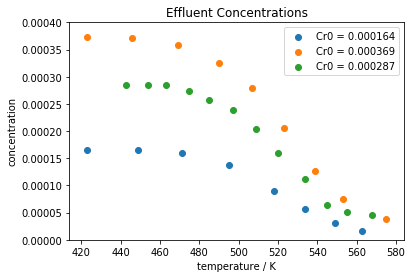

In [4]:
for expt in data:
    plt.scatter(data[expt]['T'], data[expt]['Cr'])
plt.ylim([0.0000, 0.0004])
plt.xlabel('temperature / K')
plt.ylabel('concentration')
plt.legend(['Cr0 = ' + str(data[expt]['Cr0']) for expt in data])
plt.title('Effluent Concentrations')

An initial plot of the data shows the effluent concentration decreases at higher operating temperatures. This indicates higher conversion at higher temperatures. A plot of conversion `X`

\begin{align*}
X & = \frac{C_{r,0} - C_r}{C_{r,0}}
\end{align*}

collapses the data to alsmost to a single curve.

Text(0.5,1,'Conversion at different feed concentrations')

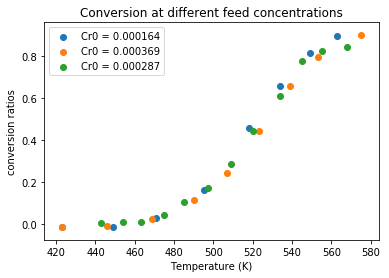

In [5]:
# compute conversion and add to data dictionary
for expt in data:
    data[expt]['X'] = 1 - data[expt]['Cr']/data[expt]['Cr0']

# plot conversion
for expt in data:
    plt.scatter(data[expt]['T'], data[expt]['X'])
plt.xlabel('Temperature (K)')
plt.ylabel('conversion ratios')
plt.legend(['Cr0 = ' + str(data[expt]['Cr0']) for expt in data])
plt.title('Conversion at different feed concentrations')

## Initial Fitting to a Model

A proposed steady-state model for the catalytic reactor is

\begin{align*}
0 & = q(C_{r,0} - C_r) - m k_0 C_r^n\left(\frac{T}{T_r}\right)^n e^{-\frac{E_a}{R T_r }\frac{T_r}{T}}
\end{align*}

The known parameters are the flow rate $q$, the mass of catalysit $m$, and a reference temperature $T_r$. The unknown parameters are the reaction order $n$, the Arrenhius pre-exponental factor $k_0$, and the reduced activation energy $\frac{E_a}{R T_r}$

Here we assemble all of the experimental data into numpy arrays `T`, `Cr`, and `Cr0`. A function is created to compute residuals of the model equation for a given set of parameter values. That function, in turn, is used to create a function to compute the norm of the residuals. `scipy.optimize.fmin` is used to find parameter values that minimize the norm of the model residuals.

In [6]:
def residuals(Cr0, T, Cr, parameters):
    n, lnk0, ERTr = parameters
    return (Cr0 - Cr) - (m/qr) * Cr**n  * np.exp(lnk0) * (T/Tr)**0 * np.exp(-ERTr*Tr/T)

def parameter_fit(Cr0, T, Cr):
    def err(parameters):
        r = residuals(Cr0, T, Cr, parameters)
        return np.linalg.norm(r)
    guess = [1, 15, 38]
    return fmin(err, guess)

T   = np.hstack([data[expt]['T'] for expt in data])
Cr  = np.hstack([data[expt]['Cr'] for expt in data])
Cr0 = np.hstack([[data[expt]['Cr0']]*len(data[expt]['Cr']) for expt in data])

Tr = 298    # The reference temperature.
qr = 0.1    # The flow rate (liters/min)
m  = 1      # The amount of catalyst (g)

n, lnk0, ERTr = parameter_fit(Cr0, T, Cr)
print("\nn    =", round(n,3), "\nlnk0 =", round(lnk0,2), "\nERTr =", round(ERTr,2))

Optimization terminated successfully.
         Current function value: 0.000104
         Iterations: 125
         Function evaluations: 226

n    = 0.651 
lnk0 = 14.7 
ERTr = 35.4


## Plotting Residuals

An important element of any parameter fitting exercise is to examine the residuals for systematic errors. The following cell plots the residuals as functions of `T`, `Cr`, and `Cr0`.

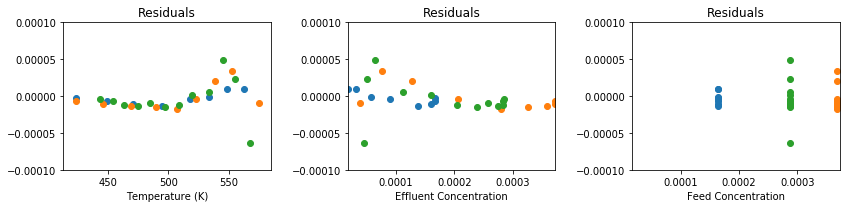

In [7]:
def plot_residuals(parameters):
    plt.figure(figsize=(12,3))
    plt.subplot(1,3,1)
    for expt in data:
        d = data[expt]
        plt.scatter(d['T'], residuals(d['Cr0'], d['T'], d['Cr'], parameters))
    plt.ylim(-0.0001, 0.0001)
    plt.xlabel('Temperature (K)')
    plt.title('Residuals')

    plt.subplot(1,3,2)
    for expt in data:
        d = data[expt]
        plt.scatter(d['Cr'], residuals(d['Cr0'], d['T'], d['Cr'], parameters))
    plt.xlim(min(Cr), max(Cr))
    plt.ylim(-0.0001, 0.0001)
    plt.xlabel('Effluent Concentration')
    plt.title('Residuals')

    plt.subplot(1,3,3)
    for expt in data:
        d = data[expt]
        plt.scatter([d['Cr0']]*len(d['T']), residuals(d['Cr0'], d['T'], d['Cr'], parameters))
    plt.xlim(min(Cr), max(Cr))
    plt.ylim(-0.0001, 0.0001)
    plt.xlabel('Feed Concentration')
    plt.title('Residuals')

    plt.tight_layout()
    
plot_residuals([n, lnk0, ERTr])

It's apparent that there is systematic error in the residuals.  To cause the minimizer to put more weight on those large residuals, a scaling factor is introduced into the norm used to measure the residual for the purpose of parameter estimation.


n    = 0.835 
lnk0 = 22.7 
ERTr = 46.73


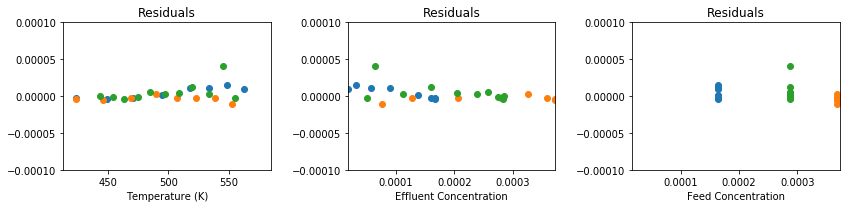

In [8]:
def parameter_fit(Cr0, T, Cr):
    def err(parameters):
        r = residuals(Cr0, T, Cr, parameters)
        return np.linalg.norm(r*Cr**2)
    guess = [1, 15, 38]
    return fmin(err, guess, disp=0)

n, lnk0, ERTr = parameter_fit(Cr0, T, Cr)
plot_residuals([n, lnk0, ERTr])
print("\nn    =", round(n,3), "\nlnk0 =", round(lnk0,2), "\nERTr =", round(ERTr,2))

## Separable Model

\begin{align*}
\frac{C_{r,0} - C_r}{C_r^n} & = \frac{m}{q} k_0 \left(\frac{T}{T_r}\right)^n e^{-\frac{E_a}{R T_r }\frac{T_r}{T}}
\end{align*}

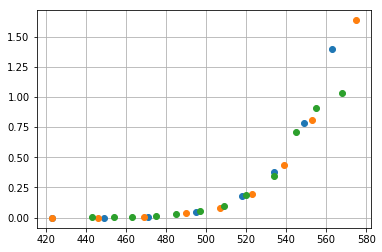

In [9]:
for expt in data:
    z = (data[expt]['Cr0'] - data[expt]['Cr'])/data[expt]['Cr']**n
    plt.plot(data[expt]['T'], z, marker='o', lw=0)
    
plt.grid()


## Bootstrap Estimates of Confidence Intervals

n        0.878861
lnk0    23.620446
ERTa    47.649978
dtype: float64
n       0.156321
lnk0    3.060243
ERTa    3.028017
dtype: float64


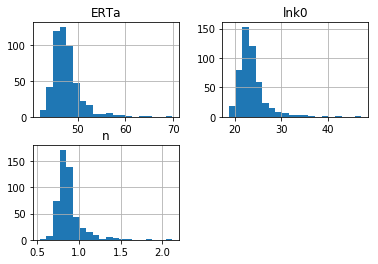

In [10]:
from random import choices
import pandas as pd

def sample(Cr0, T, Cr):
    idx = choices(range(0, len(T)), k=len(T))
    return Cr0[idx], T[idx], Cr[idx]

N = 500
df = pd.DataFrame([parameter_fit(*sample(Cr0, T, Cr)) for k in range(0,N)], columns=['n', 'lnk0', 'ERTa'])
df.hist(bins=20)

print(df.mean())
print(df.std())

In [11]:
df.cov()

,n,lnk0,ERTa
n,0.024436,0.469704,0.446259
lnk0,0.469704,9.365086,9.163002
ERTa,0.446259,9.163002,9.168887


## Pyomo Model

[0.8812118324920434, 11.063032848296652, 23.70887065329253]


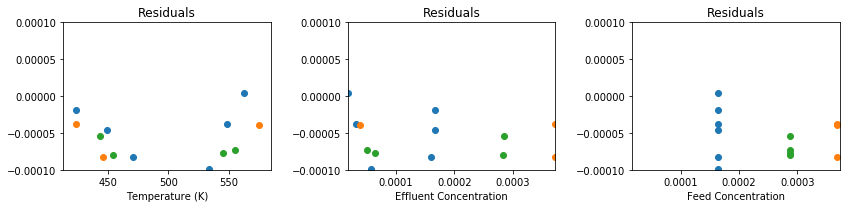

In [56]:
import pyomo.environ as pe

T   = np.hstack([data[expt]['T'] for expt in data])
Cr  = np.hstack([data[expt]['Cr'] for expt in data])
Cr0 = np.hstack([[data[expt]['Cr0']]*len(data[expt]['Cr']) for expt in data])

Tr = 298    # The reference temperature.
qr = 0.1    # The flow rate (liters/min)
m  = 1      # The amount of catalyst (g)

def pyomo_parameter_fit(Cr0, T, Cr):

    model = pe.ConcreteModel()

    K = [k for k in range(len(T))]

    model.n    = pe.Var(bounds=(0,2))
    model.lnk0 = pe.Var(domain=pe.Reals)
    model.ERTr = pe.Var(domain=pe.Reals)
    
    residuals = [Cr0[k] - Cr[k] - (m/qr)* pe.exp(model.lnk0) * pe.exp(model.n*pe.log(Cr[k])) * pe.exp(model.n*pe.log(Tr/T[k])) * 
                       pe.exp(-model.ERTr*Tr/T[k]) for k in K]

    model.obj = pe.Objective(expr=pe.sum(residuals[k]**2 for k in K), sense=pe.minimize)
    
    pe.SolverFactory('ipopt').solve(model)
    
    return [model.n(), model.lnk0(), model.ERTr()]

print(pyomo_parameter_fit(Cr0, T, Cr))
plot_residuals(pyomo_parameter_fit(Cr0, T, Cr))